In [48]:
import math
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [108]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children) # for efficiency this is internal as a set and external as a tuple?
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            
        out._backward = _backward
        
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad += (other * self.data ** (other - 1)) * out.grad
        out._backward = _backward
        
        return out
    
    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t ** 2) * out.grad
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [82]:
a = Value(2.0)
b = Value(4.0)
a - 1

Value(data=1.0, grad=0.0)

In [ ]:
a / b 
a * (1/b)
a * (b**-1)

In [79]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(
            name=uid, 
            label='{ %s | data %.4f | %.4f }' % (n.label, n.data, n.grad, ), 
            shape='record'
        )
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this to it
            dot.edge(uid+ n._op, uid)
            
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [34]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

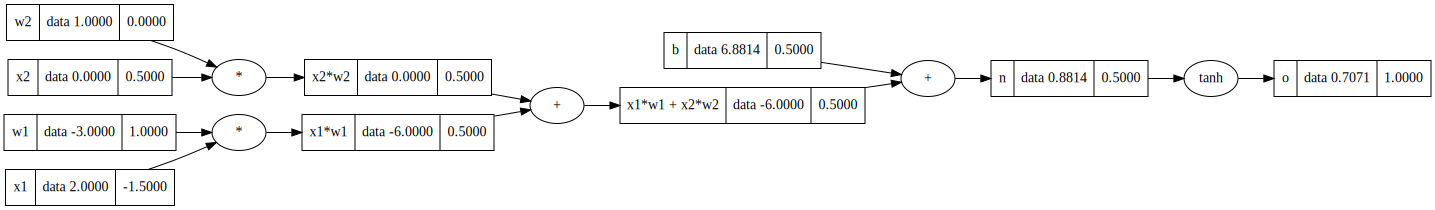

In [35]:
draw_dot(o)

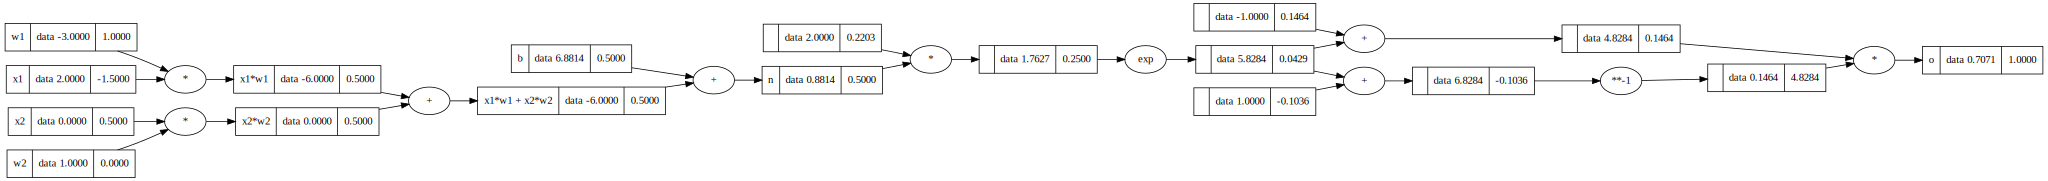

In [36]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

e = (2*n).exp()
o = (e - 1) / (e + 1)

o.label = 'o'
o.backward()
draw_dot(o)

In [38]:
import torch

In [43]:
x1 = torch.Tensor([2.0]).double()                ;  x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ;  x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ;  w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ;  w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ;  b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [160]:
import random

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
        
    def __call__(self, x):
        # w * x + b
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [161]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.6113326008974482, grad=0.0)

In [165]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

[Value(data=0.6113326008974482, grad=0.0),
 Value(data=0.6605490180871191, grad=0.0),
 Value(data=0.507873014518751, grad=0.0),
 Value(data=0.15667476682003037, grad=0.0)]

In [166]:
ypred = [n(x) for x in xs]
# mean squared error loss function
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=5.893363865427153, grad=0.0)

In [219]:
ypred = [n(x) for x in xs]
# mean squared error loss function
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=0.0002615380788352882, grad=0.0)

In [217]:
loss.backward()

In [218]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [220]:
ypred

[Value(data=0.9895139689305963, grad=0.0),
 Value(data=-0.9966092417907852, grad=0.0),
 Value(data=-0.9955587539340658, grad=0.0),
 Value(data=0.9890291603149415, grad=0.0)]

In [221]:
n.parameters()

[Value(data=-0.3579336674299874, grad=0.40270810344247376),
 Value(data=-0.017618157722682454, grad=2.1634803871489314),
 Value(data=0.5317271810471433, grad=2.920730413196565),
 Value(data=-0.9110842592886944, grad=1.9196448439968368),
 Value(data=0.557666010177125, grad=-8.475084457667913),
 Value(data=-1.1709232165038126, grad=9.36182791714289),
 Value(data=1.8467642004452094, grad=-18.389635154930616),
 Value(data=1.534596141920402, grad=-4.000555213724653),
 Value(data=0.31680607789302473, grad=-2.257379758003741),
 Value(data=-0.11196113080222943, grad=-0.6784524398282505),
 Value(data=1.0229335693848367, grad=-8.206986512354906),
 Value(data=-0.3459565342340995, grad=-3.119847573971458),
 Value(data=-1.03245652556068, grad=-0.054541355862019525),
 Value(data=0.576261203041667, grad=0.07890180119310862),
 Value(data=0.3579779547975969, grad=1.187226574772805),
 Value(data=-1.0814343794708556, grad=0.7695656490743179),
 Value(data=-0.4089120246300807, grad=0.8145124363565431),
 Va